In [94]:
import os

import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch import nn

## Loading Data

In [80]:
fullData = pd.read_csv("../HGS/clean_dataset_v3.csv", sep=",")
fullData = fullData.drop(columns=["S7", "S13"])

In [81]:
instanceData = fullData[fullData["instance_name"].str.find("3113") > 0]

In [82]:
chunkData = instanceData.sample(1000000, random_state=123456)
if "instance_name" in chunkData.columns:
    chunkData = chunkData.drop(columns=["instance_name"])

## Labelizing

In [83]:
#I shouldn't standarize the whole set
#chunkData = pd.DataFrame(preprocessing.StandardScaler().fit_transform(chunkData), columns=colNames)

nbrLabels = 2

separators = np.quantile(chunkData["cost"], [i/nbrLabels for i in range(0, nbrLabels+1)])
print(separators)
labelCols = []
#labelize data
for i in range(1, nbrLabels+1):
    labelCols.append("top"+str(i/nbrLabels))
    if i < nbrLabels:
        chunkData["top"+str(i/nbrLabels)] = (separators[i-1] <= chunkData["cost"]) & (chunkData["cost"] < separators[i])
    else:
        chunkData["top"+str(i/nbrLabels)] = (separators[i-1] <= chunkData["cost"]) & (chunkData["cost"] <= separators[i])

chunkData.head()

[18079. 21820. 26482.]


,cost,S1,S2,S3,S4,S5,S6,S8,S9,S10,S11,S12,S14,S15,S16,S17,S18,top0.5,top1.0
8467000,21937,188.705,102.1090,0.0779,0.0365,833.167,325.225,650.667,0.3613,0.0900,1167.42,0.3704,0.2457,724.958,499.732,2.2111,3.0990,False,True
5848654,24466,207.583,98.6532,0.1239,0.0877,870.692,329.966,673.538,0.3567,0.1501,1213.38,0.2692,0.0333,673.116,492.288,1.0659,4.2875,False,True
9653867,21913,194.070,93.0329,0.1004,0.0728,847.833,351.479,606.667,0.3289,0.1109,1123.25,0.3704,0.2457,723.899,495.570,2.2111,3.4792,False,True
8210497,22134,217.353,79.9058,0.1023,0.0513,832.000,301.467,617.500,0.3395,0.1144,1110.92,0.3704,0.2457,654.021,478.106,2.2111,3.7135,False,True
9150431,24716,193.138,72.3104,0.0914,0.0374,875.846,279.450,678.692,0.3479,0.1321,1224.92,0.2692,0.0333,613.014,464.931,1.0659,3.8297,False,True


## Utils
### Plotting methods

In [84]:
from sklearn.metrics import ConfusionMatrixDisplay, multilabel_confusion_matrix

## Train-test splitting

In [85]:
from torch.utils.data import Dataset
class MyDataset(Dataset):

  def __init__(self,x:np.ndarray, y:np.ndarray):
    self.x_train=torch.tensor(x, dtype=torch.float32)
    self.y_train=torch.tensor(y, dtype=torch.float32)#.squeeze(-1)

  def __len__(self):
    return len(self.x_train)

  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

In [101]:
y = chunkData[labelCols]
x = chunkData.drop(columns=labelCols + ["cost"])
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
#normalizing data, only according to train data mean and variance
scaler = preprocessing.StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

# Prepare dataset
dataset = MyDataset(x=x_train, y=y_train.to_numpy())
dataset_test = MyDataset(x=x_test, y=y_test.to_numpy())
trainloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(dataset_test, batch_size=64, shuffle=True, num_workers=0)

In [102]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score

def model_rapport(name, y_test, y_pred, precision = 8):

    accuracy = round(accuracy_score(y_test, y_pred), precision)
    precisionsc = round(precision_score(y_test, y_pred, average="macro"), precision)
    recall = round(recall_score(y_test, y_pred, average="macro"), precision)
    f1 = round(f1_score(y_test, y_pred, average="macro"), precision)
    roc = round(roc_auc_score(y_test, y_pred, average="macro"), precision)

    results = {
        "precision": precisionsc,
        "recall": recall,
        "f1": f1,
        "roc": roc,
        "accuracy": accuracy}

    print(name, "--------------------------------------")
    for key, value in results.items():
        print(key, ":", value)

    return results

## Multi Layer Perceptron

In [103]:
n_input_dim = x_train.shape[1]

#Layer size
n_hidden1 = 300  # Number of hidden nodes
n_hidden2 = 100
n_output =  nbrLabels  # Number of output nodes


class ChurnModel(nn.Module):
    def __init__(self):
        super(ChurnModel, self).__init__()
        self.layer_1 = nn.Linear(n_input_dim, n_hidden1)
        self.layer_2 = nn.Linear(n_hidden1, n_hidden2)
        self.layer_out = nn.Linear(n_hidden2, n_output)


        self.relu = nn.ReLU()
        if n_output > 1:
            self.outactivefunc = nn.Softmax(dim=1)
        else:
            self.outactivefunc = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(n_hidden1)
        self.batchnorm2 = nn.BatchNorm1d(n_hidden2)


    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.outactivefunc(self.layer_out(x))

        return x


In [106]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [109]:
model = ChurnModel()
#model.to(device)

#loss function
loss_func = nn.BCELoss()

#Optimizer
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 50

In [110]:
lossProgress_train = []
lossProgress_test = []
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(tqdm(trainloader)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data#[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print(f'[{epoch + 1}] loss: {running_loss / len(trainloader):.3f}')
    lossProgress_train.append(running_loss / len(trainloader))

    #getting loss for test
    running_loss_test = 0.0
    for i, data in enumerate(testloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data#[0].to(device), data[1].to(device)
        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        running_loss_test += loss.item()
    print(f'[{epoch + 1}] test loss: {running_loss_test / len(testloader):.3f}')
    lossProgress_test.append(running_loss_test / len(testloader))

print('Finished Training')

100%|██████████| 12500/12500 [00:55<00:00, 224.84it/s]


[1] loss: 0.096
[1] test loss: 0.054


100%|██████████| 12500/12500 [00:54<00:00, 229.91it/s]


[2] loss: 0.050
[2] test loss: 0.047


100%|██████████| 12500/12500 [00:51<00:00, 241.96it/s]


[3] loss: 0.046
[3] test loss: 0.044


100%|██████████| 12500/12500 [00:52<00:00, 237.14it/s]


[4] loss: 0.043
[4] test loss: 0.042


100%|██████████| 12500/12500 [01:00<00:00, 205.27it/s]


[5] loss: 0.042
[5] test loss: 0.041


100%|██████████| 12500/12500 [01:13<00:00, 169.81it/s]


[6] loss: 0.040
[6] test loss: 0.039


100%|██████████| 12500/12500 [01:00<00:00, 207.54it/s]


[7] loss: 0.039
[7] test loss: 0.039


100%|██████████| 12500/12500 [00:57<00:00, 216.39it/s]


[8] loss: 0.038
[8] test loss: 0.038


100%|██████████| 12500/12500 [00:56<00:00, 222.10it/s]


[9] loss: 0.038
[9] test loss: 0.038


100%|██████████| 12500/12500 [00:58<00:00, 214.07it/s]


[10] loss: 0.037
[10] test loss: 0.037


100%|██████████| 12500/12500 [01:12<00:00, 172.16it/s]


[11] loss: 0.036
[11] test loss: 0.037


100%|██████████| 12500/12500 [01:04<00:00, 193.03it/s]


[12] loss: 0.036
[12] test loss: 0.036


100%|██████████| 12500/12500 [01:07<00:00, 184.88it/s]


[13] loss: 0.035
[13] test loss: 0.036


100%|██████████| 12500/12500 [00:56<00:00, 221.48it/s]


[14] loss: 0.035
[14] test loss: 0.035


100%|██████████| 12500/12500 [00:56<00:00, 221.44it/s]


[15] loss: 0.034
[15] test loss: 0.034


100%|██████████| 12500/12500 [00:53<00:00, 233.30it/s]


[16] loss: 0.034
[16] test loss: 0.035


100%|██████████| 12500/12500 [00:54<00:00, 229.66it/s]


[17] loss: 0.034
[17] test loss: 0.034


100%|██████████| 12500/12500 [00:53<00:00, 232.80it/s]


[18] loss: 0.034
[18] test loss: 0.034


100%|██████████| 12500/12500 [00:54<00:00, 228.93it/s]


[19] loss: 0.034
[19] test loss: 0.034


100%|██████████| 12500/12500 [00:55<00:00, 224.29it/s]


[20] loss: 0.033
[20] test loss: 0.034


100%|██████████| 12500/12500 [00:55<00:00, 225.15it/s]


[21] loss: 0.033
[21] test loss: 0.033


100%|██████████| 12500/12500 [00:57<00:00, 216.77it/s]


[22] loss: 0.032
[22] test loss: 0.033


100%|██████████| 12500/12500 [00:58<00:00, 215.48it/s]


[23] loss: 0.032
[23] test loss: 0.033


100%|██████████| 12500/12500 [00:55<00:00, 226.95it/s]


[24] loss: 0.032
[24] test loss: 0.032


100%|██████████| 12500/12500 [00:55<00:00, 226.77it/s]


[25] loss: 0.032
[25] test loss: 0.033


100%|██████████| 12500/12500 [00:55<00:00, 223.49it/s]


[26] loss: 0.032
[26] test loss: 0.033


100%|██████████| 12500/12500 [00:56<00:00, 222.01it/s]


[27] loss: 0.032
[27] test loss: 0.033


100%|██████████| 12500/12500 [00:56<00:00, 221.38it/s]


[28] loss: 0.031
[28] test loss: 0.032


100%|██████████| 12500/12500 [00:51<00:00, 243.06it/s]


[29] loss: 0.031
[29] test loss: 0.032


100%|██████████| 12500/12500 [00:57<00:00, 216.81it/s]


[30] loss: 0.031
[30] test loss: 0.033


100%|██████████| 12500/12500 [01:04<00:00, 194.52it/s]


[31] loss: 0.031
[31] test loss: 0.032


100%|██████████| 12500/12500 [01:04<00:00, 193.13it/s]


[32] loss: 0.031
[32] test loss: 0.032


100%|██████████| 12500/12500 [00:57<00:00, 218.81it/s]


[33] loss: 0.031
[33] test loss: 0.032


100%|██████████| 12500/12500 [00:55<00:00, 225.75it/s]


[34] loss: 0.031
[34] test loss: 0.032


100%|██████████| 12500/12500 [00:57<00:00, 215.69it/s]


[35] loss: 0.030
[35] test loss: 0.032


100%|██████████| 12500/12500 [00:50<00:00, 245.34it/s]


[36] loss: 0.030
[36] test loss: 0.032


100%|██████████| 12500/12500 [00:57<00:00, 216.51it/s]


[37] loss: 0.030
[37] test loss: 0.032


100%|██████████| 12500/12500 [00:55<00:00, 223.70it/s]


[38] loss: 0.030
[38] test loss: 0.031


100%|██████████| 12500/12500 [01:02<00:00, 199.22it/s]


[39] loss: 0.030
[39] test loss: 0.031


100%|██████████| 12500/12500 [00:56<00:00, 220.32it/s]


[40] loss: 0.030
[40] test loss: 0.031


100%|██████████| 12500/12500 [00:57<00:00, 216.50it/s]


[41] loss: 0.030
[41] test loss: 0.031


100%|██████████| 12500/12500 [00:53<00:00, 234.32it/s]


[42] loss: 0.030
[42] test loss: 0.031


100%|██████████| 12500/12500 [00:51<00:00, 242.72it/s]


[43] loss: 0.030
[43] test loss: 0.031


100%|██████████| 12500/12500 [00:56<00:00, 221.50it/s]


[44] loss: 0.030
[44] test loss: 0.031


100%|██████████| 12500/12500 [00:56<00:00, 221.70it/s]


[45] loss: 0.030
[45] test loss: 0.031


100%|██████████| 12500/12500 [00:58<00:00, 215.01it/s]


[46] loss: 0.030
[46] test loss: 0.031


100%|██████████| 12500/12500 [00:58<00:00, 212.50it/s]


[47] loss: 0.029
[47] test loss: 0.031


100%|██████████| 12500/12500 [00:57<00:00, 218.54it/s]


[48] loss: 0.029
[48] test loss: 0.031


100%|██████████| 12500/12500 [01:00<00:00, 207.74it/s]


[49] loss: 0.029
[49] test loss: 0.031


100%|██████████| 12500/12500 [00:53<00:00, 231.68it/s]


[50] loss: 0.029
[50] test loss: 0.031
Finished Training


### Loss progress

In [111]:
del totalLossProgress_train
del totalLossProgress_test

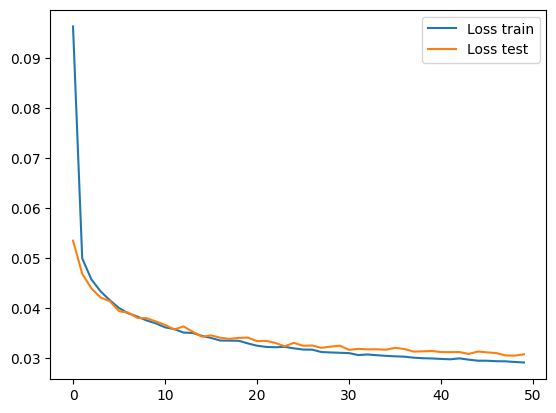

In [112]:
totalLossProgress_train = locals().get("totalLossProgress_train", [])
totalLossProgress_test = locals().get("totalLossProgress_test", [])
totalLossProgress_train += lossProgress_train
totalLossProgress_test += lossProgress_test

plt.plot([i for i in range(len(totalLossProgress_train))], totalLossProgress_train, label="Loss train")
plt.plot([i for i in range(len(totalLossProgress_test))], totalLossProgress_test, label="Loss test")
plt.legend()

### Results and scores

In [113]:
y_pred = model(torch.tensor(x_test, dtype=torch.float32))
y_pred_true = torch.round(y_pred).detach().numpy()
model_rapport("ChurnModel", y_test=y_test, y_pred=y_pred_true)

ChurnModel --------------------------------------
precision : 0.98823152
recall : 0.98823045
f1 : 0.98823
roc : 0.98823045
accuracy : 0.98823


{'precision': 0.98823152,
 'recall': 0.98823045,
 'f1': 0.98823,
 'roc': 0.98823045,
 'accuracy': 0.98823}

In [114]:
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_pred_true, cmap="viridis", normalize="all")

ValueError: multilabel-indicator is not supported

### Cross validation

In [74]:
maxepochs = 20
learning_rate = 1e-5
kf = KFold(n_splits=5, shuffle=True)
metrics = ["precision", "recall", "f1", "roc", "accuracy"]

resultsCV = {}
for metric in metrics:
    resultsCV[metric] = []

n_split=0
lossProgress_train = []
lossProgress_test = []

for train_index, test_index in kf.split(x):

    print("split", n_split, "----------------------------------------------------")

    x_train, y_train = x.iloc[train_index], y.iloc[train_index]
    x_test, y_test = x.iloc[test_index], y.iloc[test_index]

    #normalizing data, only according to train data mean and variance
    scaler = preprocessing.StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)

    # Prepare dataset
    dataset = MyDataset(x=x_train, y=y_train.to_numpy())
    dataset_test = MyDataset(x=x_test, y=y_test.to_numpy())
    trainloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True, num_workers=0)
    testloader = torch.utils.data.DataLoader(dataset_test, batch_size=10, shuffle=True, num_workers=0)

    # prepare model
    model = ChurnModel()

    #loss function
    loss_func = nn.BCELoss()

    #Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(maxepochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        print(f'[{epoch + 1}] loss: {running_loss / len(trainloader):.3f}')
        lossProgress_train.append(running_loss / len(trainloader))

        #getting loss for test
        running_loss_test = 0.0
        for i, data in enumerate(testloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # forward + backward + optimize
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            running_loss_test += loss.item()
        print(f'[{epoch + 1}] test loss: {running_loss_test / len(testloader):.3f}')
        lossProgress_test.append(running_loss_test / len(testloader))
    print('Finished Training')

    #eval
    y_pred = model(torch.tensor(x_test, dtype=torch.float32))
    y_pred_true = torch.round(y_pred).detach().numpy()
    print("Rapport split", n_split)
    metricsRapport = model_rapport("ChurnModel", y_test=y_test, y_pred=y_pred_true)

    for metric in metrics:
        resultsCV[metric].append(metricsRapport[metric])

    n_split += 1


split 0 ----------------------------------------------------
[1] loss: 0.475
[1] test loss: 0.379
[2] loss: 0.332
[2] test loss: 0.298
[3] loss: 0.277
[3] test loss: 0.255
[4] loss: 0.255
[4] test loss: 0.240
[5] loss: 0.231
[5] test loss: 0.239
[6] loss: 0.214
[6] test loss: 0.197
[7] loss: 0.205
[7] test loss: 0.207
[8] loss: 0.190
[8] test loss: 0.206
[9] loss: 0.183
[9] test loss: 0.177
[10] loss: 0.178
[10] test loss: 0.174
[11] loss: 0.180
[11] test loss: 0.174
[12] loss: 0.170
[12] test loss: 0.158
[13] loss: 0.163
[13] test loss: 0.167
[14] loss: 0.161
[14] test loss: 0.167
[15] loss: 0.161
[15] test loss: 0.158
[16] loss: 0.157
[16] test loss: 0.159
[17] loss: 0.153
[17] test loss: 0.159
[18] loss: 0.144
[18] test loss: 0.158
[19] loss: 0.150
[19] test loss: 0.147
[20] loss: 0.150
[20] test loss: 0.135
[21] loss: 0.144
[21] test loss: 0.133
[22] loss: 0.140
[22] test loss: 0.148
[23] loss: 0.139
[23] test loss: 0.149
[24] loss: 0.141
[24] test loss: 0.131
[25] loss: 0.136
[25]

In [75]:
print("Final results : ")
for metric in metrics:
    print(metric, ":", round(np.array(resultsCV[metric]).mean(), 8))

Final results : 
precision : 0.98042262
recall : 0.9806145
f1 : 0.98048924
roc : 0.9806145
accuracy : 0.9805


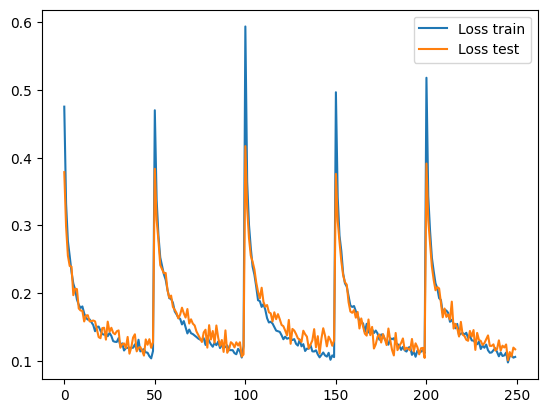

In [76]:
plt.plot([i for i in range(n_split*maxepochs)], lossProgress_train, label="Loss train")
plt.plot([i for i in range(n_split*maxepochs)], lossProgress_test, label="Loss test")
plt.legend()